In [1]:

import numpy as np

import salvus.namespace as sn
import time

from my_code.utilities import *
from pathlib import Path
import os
import salvus.flow.simple_config as sc

from material_ela_constants.Elastic_Material import Austenite
from salvus.material._details import material as md
import xarray as xr

from datetime import datetime
import cv2
from PIL import Image
from salvus.toolbox.helpers.wavefield_output import (
    WavefieldOutput,
    wavefield_output_to_xarray,
)



import numpy as np

import salvus.namespace as sn

import salvus.mesh
import salvus.mesh.layered_meshing as lm
from my_code.utilities import *
from pathlib import Path




# Directories in WSL
PROJECT_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/Project'
IMAGE_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/image'
DATA_DIR = '/home/oliver/workspace/Salvus/elastic_model/anisotropic/data'


# Directories in Windows
PROJECT_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/Project'
DATA_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/data'
IMAGE_DIR_WIN = '/mnt/d/Salvus_project/elastic_model/anisotropic/image'


# create dir if it does not exist
Path(IMAGE_DIR).mkdir(parents=True, exist_ok=True)
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
Path(IMAGE_DIR_WIN).mkdir(parents=True, exist_ok=True)
Path(DATA_DIR_WIN).mkdir(parents=True, exist_ok=True)




# Salvus site name
SALVUS_FLOW_SITE_NAME = 'oliver_wsl'
RANKS_PER_JOB = 8

# 1 MHz should run on laptops, 4 MHz and higher we recommend GPUs
CENTRAL_FREQUENCY = 1e6  # MHz

assert CENTRAL_FREQUENCY >= 1e6

--> Server: 'https://l.mondaic.com/licensing_server', User: 'bristol.support', Group: 'UniversityOfBristol'.
--> Negotiating 1 license instance(s) for 'SalvusMesh' [license version 1.0.0] for 1 seconds ...
--> Success! [Total duration: 0.43 seconds]


In [2]:
PROJECT_NAME = 'gradient'


# salvus site 
SITE_NAME = "oliver_wsl"
RANKS = 8

# number of grains
N_GRAIN = 5

# center frequency 
CENTRAL_FREQUENCY = 1e6  # MHz
# CENTRAL_FREQUENCY = 3e6  # MHz


roi_radius = 9e-3

n_txs = 32


VP = 5000.0
VS = 3000.0
RHO = 2600.0


x0, x1 = 0.0, 0.01
y0, y1 = 0.0, 0.01

time_ratio = 3
end_time = 1e-6 * time_ratio

domain = sn.domain.dim2.BoxDomain(x0=x0, x1=x1, y0=y0, y1=y1)

p = sn.Project.from_domain(
    path=Path(PROJECT_DIR_WIN, PROJECT_NAME), domain=domain, load_if_exists=True
)

# acoustic material
homogeneous_model = lm.LayeredModel(
    [
        sn.material.elastic.Velocity.from_params(rho=RHO, vp=VP, vs=VS),
    ] 
)


homogeneous_model_ab = sn.layered_meshing.MeshingProtocol(
    homogeneous_model,
    ab=salvus.mesh.simple_mesh.basic_mesh.AbsorbingBoundaryParameters(
        free_surface=False,
        number_of_wavelengths=1.5,
        reference_velocity=5000,
        reference_frequency=CENTRAL_FREQUENCY * 2,
    ),
)

mesh_homogeneous = lm.mesh_from_domain(
    domain=domain,
    model=homogeneous_model_ab,
    mesh_resolution=sn.MeshResolution(
        reference_frequency=CENTRAL_FREQUENCY * 2, elements_per_wavelength=3, model_order=4
    ),
)


Accordion(children=(HTML(value='\n                <head>\n                <style>\n                td {\n     …

[2025-10-08 21:38:52,754] INFO: Loading project from /mnt/d/Salvus_project/elastic_model/anisotropic/Project/gradient.


In [3]:

mag_ratio = 1e14

src = sn.simple_config.source.cartesian.VectorPoint2D(
        x=5e-3, y=9e-3, 
        fx=0, fy=1 * mag_ratio
        ) 

fileds = ['displacement']

rx_pos = [(1e-3, 1e-3), (3e-3, 1e-3), (5e-3, 1e-3),(7e-3, 1e-3),(9e-3, 1e-3)]
# rx_pos = [(0.01, 0.01), (0, 0)]

recs = [sn.simple_config.receiver.cartesian.Point2D(
        x=rx[0], y=rx[1], 
        fields=fileds, station_code=f"{_i:06d}",
        ) for _i, rx in enumerate(rx_pos)]

for e in p.events.list():
    p.events.delete(e)
    
p.add_to_project(
sn.EventCollection.from_sources(
        sources=src, receivers=recs, event_name_starting_index=0),
        )


center_frequency = CENTRAL_FREQUENCY
sampling_rate_in_hertz = center_frequency*100


end_time = 4e-6
wsc = sn.WaveformSimulationConfiguration(start_time_in_seconds=0, end_time_in_seconds=end_time, time_step_in_seconds=1/sampling_rate_in_hertz)



ec = sn.EventConfiguration(
    waveform_simulation_configuration=wsc,
    wavelet=sn.simple_config.stf.Ricker(center_frequency=center_frequency,time_shift_in_seconds=1e-6),
)



sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous,
    name="mesh_homogeneous",
    # Event specific configuration.
    event_configuration=ec,
)



# add simulation configuration to Project
p.add_to_project(
    sim_config, overwrite=True
    )




[2025-10-08 21:38:56,449] INFO: Deleting existing `mesh_homogeneous` entity of type `simulation_configuration` ...


In [631]:
p.viz.nb.simulation_setup(
    simulation_configuration="mesh_homogeneous", events=p.events.list()[0]
)



In [4]:
# Make a copy to add a layer in between
mesh_homogeneous_scatterers = mesh_homogeneous.copy()
centroids = mesh_homogeneous_scatterers.get_element_centroid()

center = (x1/2, y1/2)

# defect_mask = np.linalg.norm(centroids - center, axis=1) < 1e-3
defect_mask_x = (centroids[:,0]<= 9e-3) & (centroids[:,0]>= 1e-3)
defect_mask_y = (centroids[:,1]<= 6e-3) & (centroids[:,1]>= 4e-3)

defect_mask = defect_mask_x & defect_mask_y
mesh_homogeneous_scatterers.elemental_fields["RHO"] -= (
    defect_mask[:, None] * 0
)
mesh_homogeneous_scatterers.elemental_fields["VP"] -= (  
    defect_mask[:, None] * 1000
)

# mesh_homogeneous_scatterers.elemental_fields["VS"] += (  
#     defect_mask[:, None] * 1000
# )


sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous_scatterers,
    name="mesh_heterogeneous",
    # Event specific configuration.
    event_configuration=ec,
)

# add simulation configuration to Project
p.add_to_project(
    sim_config, overwrite=True
    )



p.viz.nb.simulation_setup(
    simulation_configuration='mesh_heterogeneous',
    events=p.events.list()[0],
)




[2025-10-08 21:39:05,699] INFO: Deleting existing `mesh_heterogeneous` entity of type `simulation_configuration` ...


In [5]:
# Make a copy to add a layer in between
mesh_homogeneous_scatterers = mesh_homogeneous.copy()
centroids = mesh_homogeneous_scatterers.get_element_centroid()

center = (x1/2, y1/2)

# defect_mask = np.linalg.norm(centroids - center, axis=1) < 1e-3
defect_mask_x = (centroids[:,0]<= 9e-3) & (centroids[:,0]>= 1e-3)
defect_mask_y = (centroids[:,1]<= 6e-3) & (centroids[:,1]>= 4e-3)

defect_mask = defect_mask_x & defect_mask_y
mesh_homogeneous_scatterers.elemental_fields["RHO"] -= (
    defect_mask[:, None] * 0
)
mesh_homogeneous_scatterers.elemental_fields["VP"] -= (  
    defect_mask[:, None] * 2000
)

# mesh_homogeneous_scatterers.elemental_fields["VS"] += (  
#     defect_mask[:, None] * 1000
# )


sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous_scatterers,
    name="initial_model",
    # Event specific configuration.
    event_configuration=ec,
)

# add simulation configuration to Project
p.add_to_project(
    sim_config, overwrite=True
    )



p.viz.nb.simulation_setup(
    simulation_configuration='initial_model',
    events=p.events.list()[0],
)




[2025-10-08 21:39:25,253] INFO: Deleting existing `initial_model` entity of type `simulation_configuration` ...


In [634]:
# srcs = sn.simple_config.source.cartesian.collections.ScalarPoint2DRing(
#     x=0, y=0, radius=0.09, count=1, f=1.0
# )

# for e in p.events.list():
#     p.events.delete(e)
    
    
# for _i, s in enumerate(srcs._sources):
#     all_recs = sn.simple_config.receiver.cartesian.collections.RingPoint2D(
#         x=0, y=0, radius=0.09, count=1, fields=["phi"]
#     )
#     recs = [
#         r
#         for r in all_recs._receivers
#         if np.sqrt(
#             (s.location[0] - r.location[0]) ** 2
#             + (s.location[1] - r.location[1]) ** 2
#         )
#         > 0.03
#     ]
#     p.add_to_project(
#         sn.EventCollection.from_sources(
#             sources=[s], receivers=recs, event_name_starting_index=_i
#         )
#     )
    
    
    
# wsc = sn.WaveformSimulationConfiguration(end_time_in_seconds=0.00015)

In [635]:
# center_frequency = 5e4

# ec = sn.EventConfiguration(
#     waveform_simulation_configuration=wsc,
#     wavelet=sn.simple_config.stf.Ricker(center_frequency=center_frequency),
# )

# p.add_to_project(
#     sn.SimulationConfiguration(
#         name="true_model_100kHz",
#         #
#         # Settings that influence the mesh.
#         elements_per_wavelength=2,
#         tensor_order=4,
#         max_frequency_in_hertz=center_frequency*2,
#         #
#         model_configuration=sn.ModelConfiguration(
#             background_model=None, volume_models="true_model"
#         ),
#         # Potentially event dependent settings.
#         event_configuration=ec,
#     )
# )


# p.viz.nb.simulation_setup(
#     simulation_configuration="true_model_100kHz", events=p.events.list()[0]
# )



In [7]:
p.simulations.launch(
    simulation_configuration="mesh_heterogeneous",
    events=p.events.list()[0],
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=8,
)
p.simulations.query(block=True)


[2025-10-08 21:40:36,678] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2510082140875404_bc30dbf650@oliver_wsl


VBox()

True

In [9]:
import time

p.add_to_project(
    sn.MisfitConfiguration(
        name="L2",
        observed_data="mesh_heterogeneous",
        misfit_function="L2",
        receiver_field=fileds[0],
    )
)


while not p.actions.inversion.compute_misfits(
    simulation_configuration="initial_model", 
    misfit_configuration="L2", 
    events=p.events.list()[0],
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job = 4
): time.sleep(10.0)



[2025-10-08 21:40:55,707] INFO: The same misfit_configuration with name `L2` exists already in the project. Nothing will be done.
[2025-10-08 21:40:55,911] INFO: Submitting job ...
[2025-10-08 21:40:56,111] INFO: Launched simulations for 1 events. Please check again to see if they are finished.


In [123]:
while not p.actions.inversion.compute_gradients(
    simulation_configuration="initial_model",
    misfit_configuration="L2",
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    events=p.events.list()[0],
    site_name=SALVUS_FLOW_SITE_NAME,
    ranks_per_job=4,
): time.sleep(10.0)



p.viz.nb.gradients(
    simulation_configuration="initial_model",
    misfit_configuration="L2",
    wavefield_compression=sn.WavefieldCompression(
        forward_wavefield_sampling_interval=10
    ),
    events=p.events.list()[0],
)

[2025-10-07 22:11:16,296] INFO: The following events have been simulated before, but checkpoints are not available for this combination of `site_name` and `ranks_per_job` and wavefield compression settings. They will be run again: ['event_0000']
[2025-10-07 22:11:16,424] INFO: Submitting job ...
[2025-10-07 22:11:16,647] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-10-07 22:11:26,659] INFO: Submitting job ...
[2025-10-07 22:11:26,786] INFO: Launched adjoint simulations for 1 events. Please check again to see if they are finished.


In [10]:
sampling_rate_in_hertz = CENTRAL_FREQUENCY*100

ed = p.waveforms.get(data_name="mesh_heterogeneous", events=p.events.list()[0])[0]
data_true = ed.get_waveform_data_xarray(receiver_field='displacement')
time = data_true.time
ed = p.waveforms.get(data_name="initial_model", events=p.events.list()[0])[0]
data_init = ed.get_waveform_data_xarray(receiver_field='displacement')
time = data_init.time


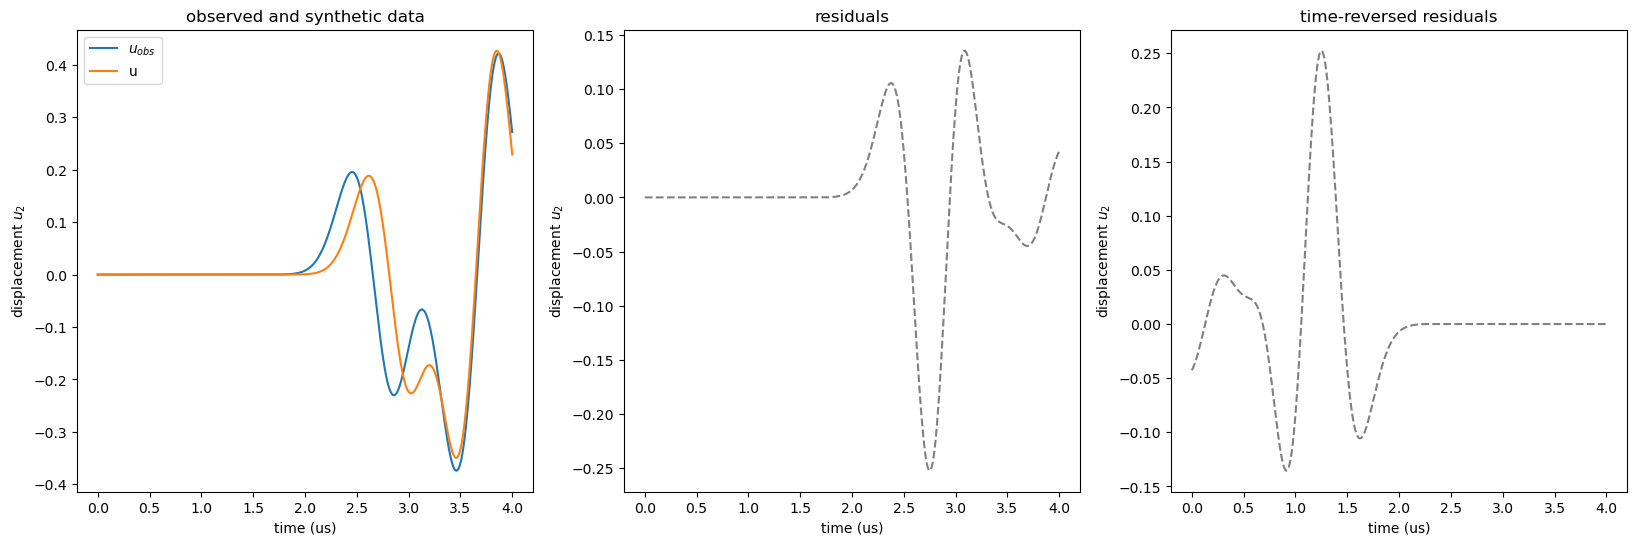

In [11]:
id = 6
f_adj_0 =  (data_true[id] - data_init[id]) /data_true.max()

fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=100)


axs[0].plot(time*1e6, data_true[id]/data_true.max())
axs[0].plot(time*1e6, data_init[id]/data_true.max())
axs[0].legend([r'$u_{obs}$', 'u'])
axs[0].set_xlabel('time (us)')
axs[0].set_ylabel(r'displacement $u_2$')
axs[0].set_title('observed and synthetic data')


axs[1].plot(time*1e6, f_adj_0, color='gray',linestyle='--')
axs[1].set_xlabel('time (us)')
axs[1].set_ylabel(r'displacement $u_2$')
axs[1].set_title('residuals')


axs[2].plot(time*1e6, -np.flip(f_adj_0), color='gray',linestyle='--')
axs[2].set_xlabel('time (us)')
axs[2].set_ylabel(r'displacement $u_2$')
axs[2].set_title('time-reversed residuals')

plt.savefig(Path(IMAGE_DIR_WIN, PROJECT_NAME + fr'_adjoint_source.png'))


In [124]:
fileds = ["strain"]

# simulation with volume data (full wavefield)
p.simulations.launch(
    ranks_per_job=4,
    site_name=SALVUS_FLOW_SITE_NAME,
    events=p.events.list()[0],
    simulation_configuration="initial_model",
    extra_output_configuration={
        "volume_data": {
            "sampling_interval_in_time_steps": 10,
            "fields": fileds,
        },
    },
    # We have previously simulated the same event but without
    # extra output. We have to thus overwrite the existing
    # simulation.
    delete_conflicting_previous_results=True,
)

p.simulations.query(block=True)


[2025-10-07 22:13:06,842] INFO: delete_conflicting_previous_results is set to True. Deleting results for simulation configuration initial_model and event event_0000.
[2025-10-07 22:13:06,983] INFO: Removing contents of `/mnt/d/Salvus_project/elastic_model/anisotropic/Project/gradient/EVENTS/event_0000/WAVEFORM_DATA/INTERNAL/72/7b/006434491a48`.
[2025-10-07 22:13:07,184] INFO: Submitting job ...
Uploading 1 files...

🚀  Submitted job_2510072213285439_2ca0314ec8@oliver_wsl


VBox()

True

In [ ]:
strain_field  = ed.get_wavefield_output(output_type='volume', field='strain').data


In [128]:
strain_field.shape

(41, 1295, 3, 25)

In [ ]:
mesh_homogeneous.jacobian_at_nodes()

(1295, 25, 2, 2)

In [ ]:
strain_t0 = strain_field[0,:,:,:]


In [105]:
ed = p.waveforms.get(data_name="initial_model", events=p.events.list()[0])[0]

mesh = p.simulations.get_mesh("initial_model")
strain_field  = wavefield_output_to_xarray(
    ed.get_wavefield_output(output_type='volume', field='strain'), 
    mesh.points).T.values


Finding enclosing elements (pass 1 of auto):   0%|          | 0/21009 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/8 [00:00<?, ?it/s]

In [75]:
# Make a copy to add a layer in between
mesh_homogeneous_scatterers = mesh_homogeneous.copy()
centroids = mesh_homogeneous_scatterers.get_element_centroid()

center = (x1/2, y1/2)

# defect_mask = np.linalg.norm(centroids - center, axis=1) < 1e-3
defect_mask_x = (centroids[:,0]<= 9e-3) & (centroids[:,0]>= 1e-3)
defect_mask_y = (centroids[:,1]<= 6e-3) & (centroids[:,1]>= 4e-3)

defect_mask = defect_mask_x & defect_mask_y
mesh_homogeneous_scatterers.elemental_fields["RHO"] -= (
    defect_mask[:, None] * 0
)
mesh_homogeneous_scatterers.elemental_fields["VP"] -= (  
    defect_mask[:, None] * 1000
)

# mesh_homogeneous_scatterers.elemental_fields["VS"] += (  
#     defect_mask[:, None] * 1000
# )


In [65]:
# Make a copy to add a layer in between
mesh_homogeneous_scatterers = mesh_homogeneous.copy()
centroids = mesh_homogeneous_scatterers.get_element_centroid()

center = (x1/2, y1/2)

# defect_mask = np.linalg.norm(centroids - center, axis=1) < 1e-3
defect_mask_x = (centroids[:,0]<= 9e-3) & (centroids[:,0]>= 1e-3)
defect_mask_y = (centroids[:,1]<= 6e-3) & (centroids[:,1]>= 4e-3)

defect_mask = defect_mask_x & defect_mask_y

In [77]:
defect_mask.shape

(1295,)

In [58]:
mesh = mesh_homogeneous.copy()


In [63]:
mesh.elemental_fields['VP'].shape

(1295, 25)

In [ ]:
def generate_mesh_from_model_m(m, mesh):
    mesh = mesh.copy()
    mesh.elemental_fields["VP"] -= m
    
    return mesh



def cal_mistf_adjoint_source(u_obs, u):
    sampling_rate = u_obs.sampling_rate_in_hertz
    diff = u_obs - u
    mistif = 1/2 * 1/sampling_rate * (diff**2).sum() 
    adjoint_src = -np.flip(diff, axis=1)
    return mistif.values, {'X':adjoint_src.sel(component='X'), 'Y':adjoint_src.sel(component='Y')}
    

def generate_adjoint_source(event, sampling_rate_in_hertz, iteration=0):
    rec_loc, src_loc = p.events.get(event).receivers, p.events.get(event).sources
    src_adj_loc = [r.location for r in rec_loc]
    rxs_adj_loc = [t.location for t in src_loc]

    stf_ls = [sc.stf.Custom.from_array(
        np.array([stf_adj['X'][i], stf_adj['Y'][i]]),
        sampling_rate_in_hertz=sampling_rate_in_hertz,
        start_time_in_seconds=0.0,
    ) for i in range(len(src_adj_loc))]

    srcs = [sn.simple_config.source.cartesian.VectorPoint2D(
        x= t[0], y= t[1],
        fx=1, fy=1,
    ) for t in src_adj_loc]

    recs = [sn.simple_config.receiver.cartesian.Point2D(
            x=rx[0], y=rx[1], 
            fields=['displacement'], station_code=f"{_i:06d}",
            ) for _i, rx in enumerate(rxs_adj_loc)]
    
    
    event_name = event + f'_adjoint_iteration_{iteration}'

    p.add_to_project(sn.Event(event_name=event_name, sources=srcs, receivers=recs)     )

    wsc = sn.WaveformSimulationConfiguration(start_time_in_seconds=0, end_time_in_seconds=end_time, time_step_in_seconds=1/sampling_rate_in_hertz)

    ec = sn.EventConfiguration(
            wavelet=stf_ls,
            waveform_simulation_configuration=wsc,
    )
    

    return event_name, ec

def adjoint_wavefield(mesh, event, iteration=0, fields=["strain"], sampling_rate_in_hertz=CENTRAL_FREQUENCY*100, sampling_interval_in_time_steps=10):
    event_adjoint, ec = generate_adjoint_source(event, sampling_rate_in_hertz, iteration=iteration)
    
    adjoint_simulation = f"adjoint_simulation_{iteration}"
    sim_config = sn.UnstructuredMeshSimulationConfiguration(
        unstructured_mesh=mesh,
        name=adjoint_simulation,
        # Event specific configuration.
        event_configuration=ec
        )
    
    p.add_to_project(sim_config, overwrite=True)
    # simulation with volume data (full wavefield)
    p.simulations.launch(
        ranks_per_job=RANKS_PER_JOB,
        site_name=SALVUS_FLOW_SITE_NAME,
        events=event_adjoint,
        simulation_configuration=adjoint_simulation,
        extra_output_configuration={
            "volume_data": {
                "sampling_interval_in_time_steps": sampling_interval_in_time_steps,
                "fields": fields,
            },
        },
        delete_conflicting_previous_results=True,
    )

    p.simulations.query(block=True)
    ed = p.waveforms.get(data_name=adjoint_simulation, events=event_adjoint)[0]
    strain_field_adj  = wavefield_output_to_xarray(
        ed.get_wavefield_output(output_type='volume', field=fileds[0]), 
        mesh.points).T.values
    
    return strain_field_adj
    
    
def full_wavefield(mesh, simulation, event, fields=["strain"], sampling_interval_in_time_steps=10):
    
    p.simulations.launch(
    ranks_per_job=RANKS_PER_JOB,
    site_name=SALVUS_FLOW_SITE_NAME,
    events=event,
    simulation_configuration=simulation,
    extra_output_configuration={
        "volume_data": {
            "sampling_interval_in_time_steps": sampling_interval_in_time_steps,
            "fields": fields,
        },
    },
    delete_conflicting_previous_results=True,
    )

    p.simulations.query(block=True)
    
    
    ed = p.waveforms.get(data_name=simulation, events=event)[0]
    strain_field  = wavefield_output_to_xarray(
        ed.get_wavefield_output(output_type='volume', field=fields[0]), mesh.points).T.values
    return strain_field






mistif, stf_adj = cal_mistf_adjoint_source(data_true, data_init)



event = p.events.list()[0]

m = defect_mask[:, None] * 1000

mesh = generate_mesh_from_model_m(m, mesh=mesh_homogeneous)

# strain shape (n_node, 3, t_step) 
strain_field = full_wavefield(mesh=mesh, simulation='initial_model', event=event, fields=["strain"], sampling_interval_in_time_steps=10) 
strain_field_adj = adjoint_wavefield(mesh=mesh, event=event, iteration=0, fields=["strain"], sampling_rate_in_hertz=CENTRAL_FREQUENCY*100, sampling_interval_in_time_steps=10)




# stf_adj['X'][1,:] = 0
# stf_adj['X'][0,:]=0
mistif

[2025-10-07 22:07:11,735] INFO: Data for 1 event(s) already exists. They will not be submitted again. The requested extra_output_configuration is fully contained in the existing results. If you really want to rerun the simulations, please delete the results first using p.simulations.delete_results().


VBox()

Finding enclosing elements (pass 1 of auto):   0%|          | 0/21009 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/8 [00:00<?, ?it/s]

[2025-10-07 22:07:13,267] INFO: Submitting job ...
Uploading 6 files...

🚀  Submitted job_2510072207491963_3f145b580e@oliver_wsl


VBox()

Finding enclosing elements (pass 1 of auto):   0%|          | 0/21009 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/7 [00:00<?, ?it/s]

array(0.00652498)

In [ ]:
event = ev = p.events.get_all()[0]

src_adj_loc = [r.location for r in event.receivers]
rxs_adj_loc = [t.location for t in event.sources]

stf_ls = [sc.stf.Custom.from_array(
    np.array([stf_adj['X'][i], stf_adj['Y'][i]]),
    sampling_rate_in_hertz=sampling_rate_in_hertz,
    start_time_in_seconds=0.0,
) for i in range(len(src_adj_loc))]

srcs = [sn.simple_config.source.cartesian.VectorPoint2D(
    x= t[0], y= t[1],
    fx=1, fy=1,
) for t in src_adj_loc]

recs = [sn.simple_config.receiver.cartesian.Point2D(
        x=rx[0], y=rx[1], 
        fields=['displacement'], station_code=f"{_i:06d}",
        ) for _i, rx in enumerate(rxs_adj_loc)]

In [645]:
event_name = "event_adjoint_0"
if event_name in p.events.list():
        p.events.delete("event_adjoint_0")


p.add_to_project(sn.Event(event_name=f"event_adjoint_0", sources=srcs, receivers=recs)     )


sampling_rate_in_hertz = center_frequency*100


wsc = sn.WaveformSimulationConfiguration(start_time_in_seconds=0, end_time_in_seconds=end_time, time_step_in_seconds=1/sampling_rate_in_hertz)



ec = sn.EventConfiguration(
        wavelet=stf_ls,
        waveform_simulation_configuration=wsc,
)


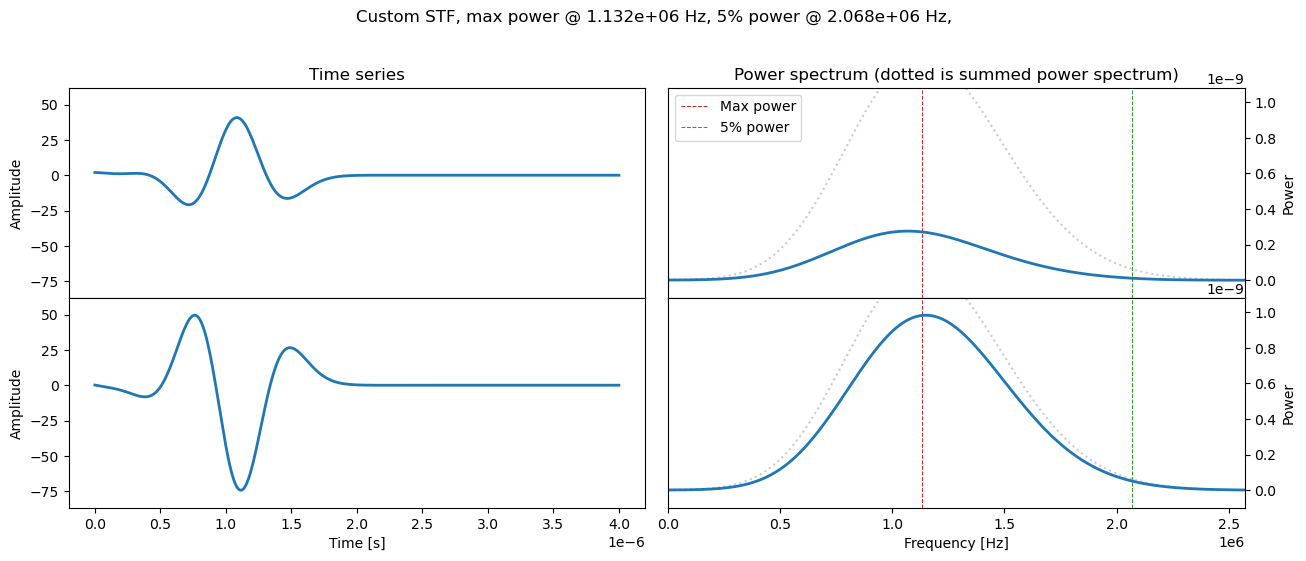

In [646]:
ec.wavelet[4].plot()
# plt.savefig(Path(IMAGE_DIR_WIN, PROJECT_NAME + fr'_stf'))


In [647]:



sim_config = sn.UnstructuredMeshSimulationConfiguration(
    unstructured_mesh=mesh_homogeneous_scatterers,
    name="adjoint_simulation_0",
    # Event specific configuration.
    event_configuration=ec,
)


p.add_to_project(sim_config, overwrite=True)




fileds = ["strain"]

# simulation with volume data (full wavefield)
p.simulations.launch(
    ranks_per_job=4,
    site_name=SALVUS_FLOW_SITE_NAME,
    events="event_adjoint_0",
    simulation_configuration="adjoint_simulation_0",
    extra_output_configuration={
        "volume_data": {
            "sampling_interval_in_time_steps": 10,
            "fields": fileds,
        },
    },
    # We have previously simulated the same event but without
    # extra output. We have to thus overwrite the existing
    # simulation.
    delete_conflicting_previous_results=True,
)

p.simulations.query(block=True)

[2025-10-06 18:50:22,781] INFO: Submitting job ...
Uploading 6 files...

🚀  Submitted job_2510061850003130_505e29dba5@oliver_wsl


VBox()

True

In [648]:
mesh = p.simulations.get_mesh("initial_model")
ed = p.waveforms.get(data_name="adjoint_simulation_0", events='event_adjoint_0')[0]
strain_field_adj  = wavefield_output_to_xarray(
    ed.get_wavefield_output(output_type='volume', field='strain'), 
    mesh.points).T.values

Finding enclosing elements (pass 1 of auto):   0%|          | 0/21009 [00:00<?, ?it/s]

Extracting wavefield to regular grid:   0%|          | 0/8 [00:00<?, ?it/s]

TypeError: 'module' object is not subscriptable

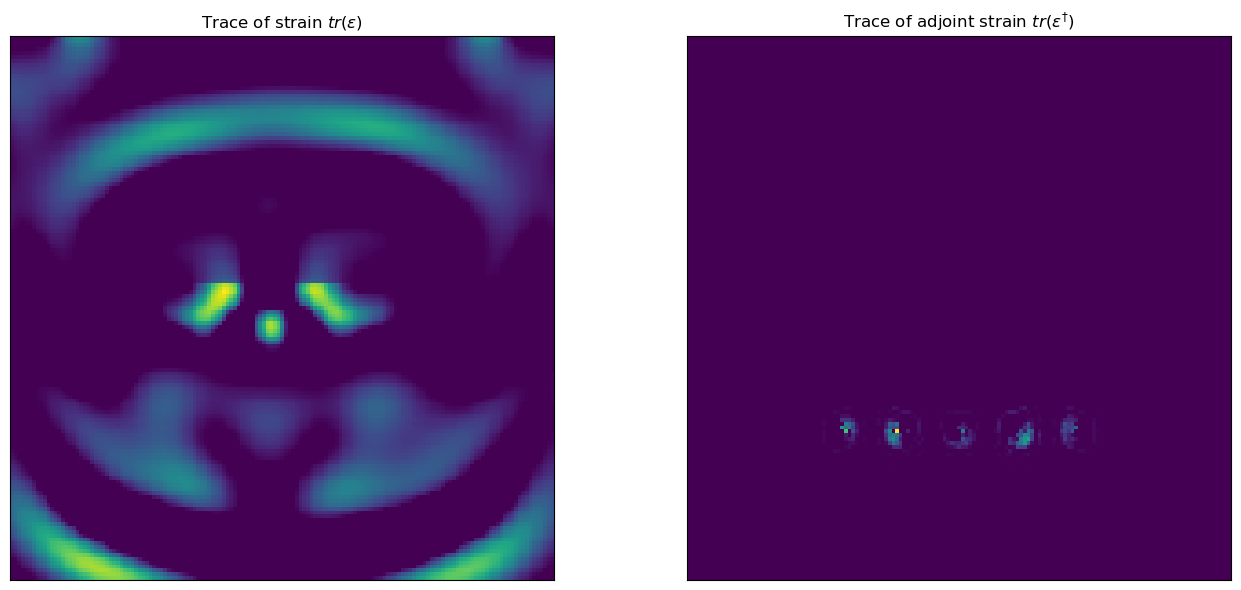

In [111]:
t_idx = 40
nx, ny = int(np.sqrt(mesh.number_of_elements)) * 4 +9, int(np.sqrt(mesh.number_of_elements)) * 4 +1

# print(int(time[t_idx]*1e6))

# Prepare adjoint strain
strain_adj_tr = strain_field_adj[:,0,:].reshape((nx, ny,-1)) + strain_field_adj[:,1,:].reshape((nx, ny,-1))
strain_adj_tr_t = strain_adj_tr[:, :, -t_idx].T
strain_adj_tr_t /= strain_adj_tr_t.max()

# Prepare original strain
strain_field /= strain_field.max()
strain_tr = strain_field[:,0,:].reshape((nx, ny,-1)) + strain_field[:,1,:].reshape((nx, ny,-1))
strain_tr_t = strain_tr[:, :, t_idx].T
strain_tr_t /= strain_tr_t.max()

# Grid edges
x_edges = np.linspace(0, 1, nx+1)
y_edges = np.linspace(0, 1, ny+1)

# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=100)


# Plot original strain
axs[0].pcolormesh(x_edges, y_edges, strain_tr_t, cmap="viridis", vmin=0, vmax=1,
                  edgecolors='white', linewidth=0, rasterized=True)
axs[0].set_aspect("equal")
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title(r"Trace of strain $tr(\epsilon)$")



# Plot adjoint strain
axs[1].pcolormesh(x_edges, y_edges, strain_adj_tr_t, cmap="viridis", vmin=0, vmax=1,
                  edgecolors='white', linewidth=0, rasterized=True)
axs[1].set_aspect("equal")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title(r"Trace of adjoint strain $tr(\epsilon^{\dag})$")


plt.tight_layout()

plt.savefig(Path(IMAGE_DIR_WIN, PROJECT_NAME + fr'_adjoint_strain_t_{int(time[t_idx]*1e6)}.png'))


plt.show()


In [650]:
def global_nodal_field(mesh, filed='VP'):

    VP_element = mesh.element_nodal_fields[filed]
    conn = mesh.connectivity
    n_nodes = mesh.number_of_nodes
    # Prepare arrays for accumulation
    VP_global = np.zeros(n_nodes)
    counts = np.zeros(n_nodes)

    # Accumulate values
    np.add.at(VP_global, conn, VP_element)
    np.add.at(counts, conn, 1)

    # Avoid division by zero
    counts[counts == 0] = 1
    VP_global /= counts
    return VP_global

vp_global = global_nodal_field(mesh, 'VP')

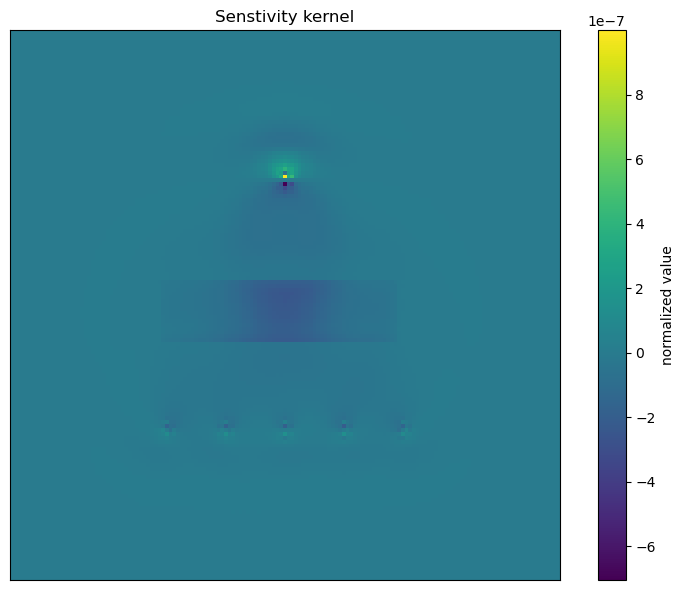

In [112]:
strain_tr_adj = strain_field_adj[:,0,:] + strain_field_adj[:,1,:] 
strain_tr = strain_field[:,0,:] + strain_field[:,1,:]


gradient = (np.flip(strain_tr_adj,axis=1)  * strain_tr ).sum(axis=1)
gradient = -gradient.reshape((nx, ny)).T 

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)


pc = ax.pcolormesh(x_edges, y_edges, gradient, cmap="viridis",
                   edgecolors='white', linewidth=0, rasterized=True)  # Thicker grid lines

# Colorbar
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label("normalized value")

# Hide all ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Keep square aspect and clean layout
ax.set_aspect("equal")
plt.title("Senstivity kernel")
plt.tight_layout()
plt.savefig(Path(IMAGE_DIR_WIN, PROJECT_NAME + fr'_gradient.png'))

plt.show()


In [652]:
# region of interest for inversion
centroids = mesh_homogeneous_scatterers.get_element_centroid()
# roi = np.linalg.norm(centroids - np.array([x1/2, y1/2]), axis=1) < roi_radius
defect_mask_x = (centroids[:,0]<= 9e-3) & (centroids[:,0]>= 1e-3)
defect_mask_y = (centroids[:,1]<= 7e-3) & (centroids[:,1]>= 3e-3)
roi = defect_mask_x & defect_mask_y


mesh_roi = mesh_homogeneous_scatterers.copy()
fields = [field for field in mesh_roi.elemental_fields]
for field in fields:
    mesh_roi.elemental_fields.pop(field)
mesh_roi.attach_field(
    "region_of_interest",
    np.broadcast_to(roi[:, None], mesh_roi.connectivity.shape),
)



mesh_roi

In [653]:
p.add_to_project(
    sn.InverseProblemConfiguration(
        name="salvus_inversion",
        prior_model="mesh_homogeneous",
        events=p.events.list()[0],
        mapping=sn.Mapping(
            scaling="absolute", inversion_parameters=["VP"],region_of_interest=mesh_roi,
        ),
        # preconditioner=sn.ConstantSmoothing({"VP": 0.01, "RHO": 0.01}),
        method=sn.TrustRegion(initial_trust_region_linf=10.0),
        misfit_configuration="L2",
        wavefield_compression=sn.WavefieldCompression(
            forward_wavefield_sampling_interval=10
        ),
        job_submission=sn.SiteConfig(
            site_name=SALVUS_FLOW_SITE_NAME, ranks_per_job=4
        ),
    )
)
# p.inversions.add_iteration(inverse_problem_configuration="my_inversion")
# p.inversions.resume(
#     inverse_problem_configuration="my_inversion",
# )
# p.viz.nb.iteration(
#     inverse_problem_configuration="my_inversion", iteration_id=0
# )

for i in range(10):
    p.inversions.iterate(
        inverse_problem_configuration="salvus_inversion",
        timeout_in_seconds=360,
        ping_interval_in_seconds=10,
        delete_disposable_files="all",
    )


[2025-10-06 18:50:30,336] INFO: Adding new iteration #0.
[2025-10-06 18:50:30,473] INFO: Resuming iteration #0.

[2025-10-06 18:50:30,482] INFO: 1 new tasks have been issued.
[2025-10-06 18:50:30,482] INFO: Processing task `misfit_and_gradient`
[2025-10-06 18:50:30,904] INFO: Submitting job ...
[2025-10-06 18:50:31,110] INFO: Launched simulations for 1 events. Please check again to see if they are finished.
[2025-10-06 18:50:31,111] INFO: Some tasks of iteration #0 are still running. Please check again later.
[2025-10-06 18:50:41,938] INFO: Processing task `misfit_and_gradient`
[2025-10-06 18:50:44,156] INFO: Submitting job ...
[2025-10-06 18:50:44,287] INFO: Launched adjoint simulations for 1 events. Please check again to see if they are finished.
[2025-10-06 18:50:44,288] INFO: Some tasks of iteration #0 are still running. Please check again later.
[2025-10-06 18:50:54,357] INFO: Processing task `misfit_and_gradient`
[2025-10-06 18:50:56,544] INFO: 
Iteration 0: Number of events: 1	 

In [654]:
p.viz.nb.inversion(inverse_problem_configuration="salvus_inversion")